<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/Phase2/1.WordEmbeddings/Word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using word embeddings

This notebook contains the second code sample found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

In [2]:
import keras
keras.__version__

'2.2.5'

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to http://mng.nz/0tIo and download the raw IMDB dataset. Uncompress it. Now, let's collect the individual training reviews into a list of strings, one string per review. You'll also collect the review labels (positive/negative) into a labels list.

In [6]:
## keras provides the processed Imdb dataset as list of word-indexes.
## We need to get the raw Imdb dataset
!wget --no-check-certificate http://mng.bz/0tIo

--2020-01-24 11:16:28--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2020-01-24 11:16:28--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2020-01-24 11:16:28--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.14.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.14.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo.1’

0tIo.1              100%[===================>]  57.90M  34.3MB/s    in 1.7s    

2020-01-24 11:16:30 (34.3 MB/s) - ‘0tIo.1’ saved [60711700/60711

In [0]:
!unzip -q 0tIo

In [0]:
import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 8000  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-24 11:21:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-24 11:21:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-24 11:21:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [12]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [13]:
glove_dir = '/content/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 660,065
Trainable params: 660,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 231us/step - loss: 0.6755 - acc: 0.6100 - val_loss: 0.6321 - val_acc: 0.6432
Epoch 2/10
8000/8000 [==============================] - 1s 181us/step - loss: 0.5516 - acc: 0.7181 - val_loss: 0.5929 - val_acc: 0.6864
Epoch 3/10
8000/8000 [==============================] - 1s 181us/step - loss: 0.4750 - acc: 0.7749 - val_loss: 0.6038 - val_acc: 0.6847
Epoch 4/10
8000/8000 [==============================] - 1s 177us/step - loss: 0.4112 - acc: 0.8151 - val_loss: 0.6689 - val_acc: 0.6831
Epoch 5/10
8000/8000 [==============================] - 1s 182us/step - loss: 0.3472 - acc: 0.8464 - val_loss: 0.7889 - val_acc: 0.6743
Epoch 6/10
8000/8000 [==============================] - 1s 180us/step - loss: 0.2941 - acc: 0.8748 - val_loss: 0.7838 - val_acc: 0.6525
Epoch 7/10
8000/8000 [===============

Let's plot its performance over time:

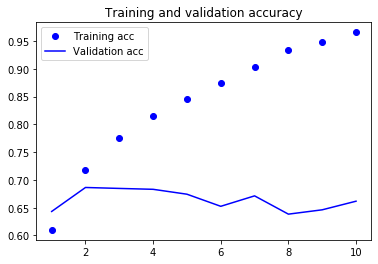

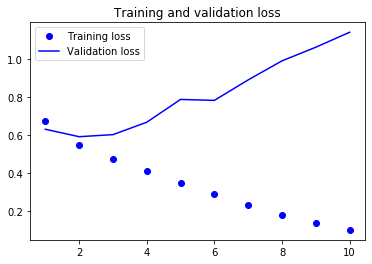

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 660,065
Trainable params: 660,065
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 3s 370us/step - loss: 0.5639 - acc: 0.7077 - val_loss: 0.3997 - val_acc: 0.8221
Epoch 2/10
8000/8000 [==============================] - 3s 34

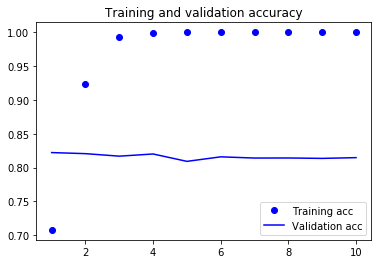

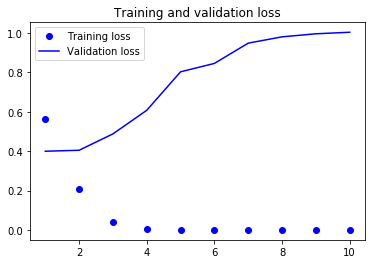

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [24]:
model.load_weights('pre_trained_glove_model.h5')
score = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 38us/step


In [25]:
print('The accuracy of test data is: ', score[1])

The accuracy of test data is:  0.66464
